# Solar prediction

In [1]:
import xarray as xr
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.preprocessing import StandardScaler
from temp_clustering import cluster_temp_diff

In [20]:
def smooth_butter(data, order):
    b, a = signal.butter(order, 0.125)
    y = signal.filtfilt(b, a, data, padlen=150)
    return y

In [2]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

In [8]:
# Dataset for Solar Forcing
df_solar = {'time':ds_solar.time.values, 'TSI':ds_solar.TSI.values.flatten()}

# Dataset for volcanic forcing
df_volc = {'time':ds_volc.time.values, 'AOD':ds_volc.AOD.values.flatten()}

# Dataset for R1
df_R1 = {'time': ds_temp_r1.time.values, 'lon':ds_temp_r1.lon.values, 'lat': ds_temp_r1.lat.values, 'T2m':ds_temp_r1.T2m.values}

# Dataset for R2
df_R2 = {'time': ds_temp_r2.time.values, 'lon':ds_temp_r2.lon.values, 'lat': ds_temp_r2.lat.values, 'T2m':ds_temp_r2.T2m.values}

In [3]:
cluster_rel = cluster_temp_diff(ds_temp_r1)

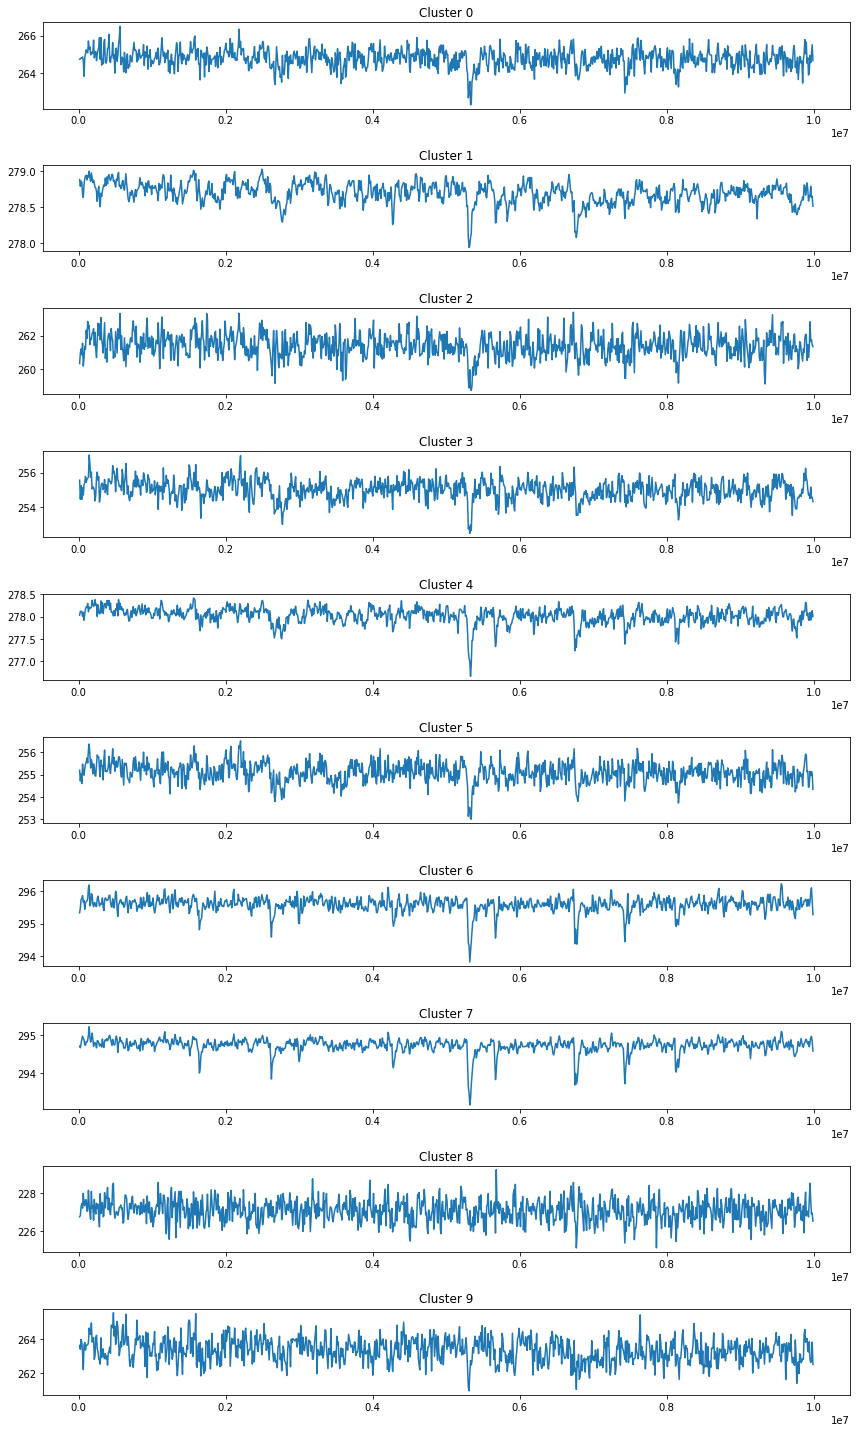

In [19]:
fig, ax = plt.subplots(np.unique(cluster_rel).shape[0], 1, figsize = (12,20))
for vals in np.unique(cluster_rel):
    ax[vals].plot(df_R1['time'], np.mean(df_R1['T2m'][:,cluster_rel == vals], axis = 1))
    ax[vals].set_title("Cluster {}".format(vals))
    
fig.tight_layout()

Verwende Ergebnis aus Cluster 8 als Input:

In [22]:
TR1_cluster8 = df_R1['T2m'][:,cluster_rel == 8]
TR1_cluster8.shape

(999, 1027)

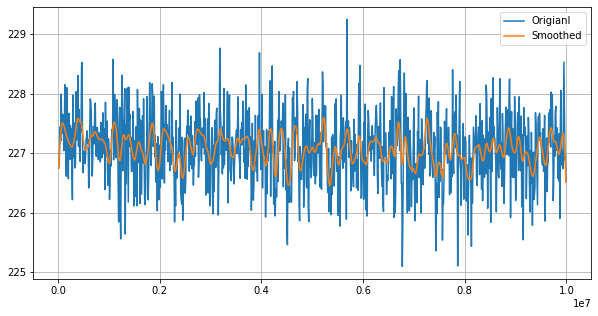

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df_R1['time'], np.mean(df_R1['T2m'][:,cluster_rel == 8], axis = 1), label = 'Origianl')
ax.plot(df_R1['time'], smooth_butter(np.mean(df_R1['T2m'][:,cluster_rel == 8], axis = 1),2), label = 'Smoothed')
ax.grid()
ax.legend();

## Tensorflow Model

In [27]:
def reshape_data_window_approach(df, output, window_size, 
                                 step_size, target_size, BoolVolcano):

    labels = []
    data = []
    
    final_idx = df.shape[0] - window_size
    for i in range(0, df.shape[0], step_size):
        if i+window_size <= df.shape[0]:
            idx = range(i,i+window_size)
            if all(BoolVolcano[i+window_size:i+window_size+target_size]):
                data.append(df[idx,:,:])
                labels.append(np.reshape(output[idx],(window_size)))
    return np.array(data), np.array(labels)